# Video Game Sales Prediction

## Part 0: Introduction

This dataset, inspired by Gregory Smith's web scrape of VGChartz, extends video game sales data with additional variables sourced from Metacritic. It includes information on game sales by region, critic and user scores, and game metadata such as platform, genre, and ESRB ratings. 

### Objective: To create a classification model that can predict the global sale of a video game (Note the target column in the dataset is Global_Sales)

We will follow the following steps:
1. Read the Data
2. Reduce the data by
   - Removing N/A values
   - Removing Outliers
3. Data Exploration
   - Looking into the different types of games (consoles, PCs, etc..)
4. Feature Engineering
   - One Hot encoding categorical variables
5. Modeling
   - K Nearest Neighbor
   - Logistic Regression
   - Random Forest
   - Decision Tree


# Imports

In [267]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Reading and Understanding the DataSet

In [268]:
file_path = "Video_Games_Sales_as_at_22_Dec_2016.csv"
df = pd.read_csv(file_path)

df.shape

(16719, 16)

In [269]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16719 entries, 0 to 16718
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16717 non-null  object 
 1   Platform         16719 non-null  object 
 2   Year_of_Release  16450 non-null  float64
 3   Genre            16717 non-null  object 
 4   Publisher        16665 non-null  object 
 5   NA_Sales         16719 non-null  float64
 6   EU_Sales         16719 non-null  float64
 7   JP_Sales         16719 non-null  float64
 8   Other_Sales      16719 non-null  float64
 9   Global_Sales     16719 non-null  float64
 10  Critic_Score     8137 non-null   float64
 11  Critic_Count     8137 non-null   float64
 12  User_Score       10015 non-null  object 
 13  User_Count       7590 non-null   float64
 14  Developer        10096 non-null  object 
 15  Rating           9950 non-null   object 
dtypes: float64(9), object(7)
memory usage: 2.0+ MB


## Features

1. **Name**: The title of the video game *(Nominal)* – serves as an identifier for each game.

2. **Platform**: The gaming console or platform for which the game was released *(Nominal)* – e.g., PS4, Xbox, PC.

3. **Year_of_Release**: The year when the game was released *(Discrete)* – Although recorded as whole numbers, this variable represents a time series trend.

4. **Genre**: The category or type of the game *(Nominal)* – e.g., Action, Adventure, Sports.

5. **Publisher**: The company responsible for publishing and distributing the game *(Nominal)* – e.g., Nintendo, EA Sports.

6. **NA_Sales**: Total sales in millions of units in North America *(Continuous)* – Indicates the success of the game in the North American market.

7. **EU_Sales**: Total sales in millions of units in Europe *(Continuous)* – Measures the game’s performance in the European market.

8. **JP_Sales**: Total sales in millions of units in Japan *(Continuous)* – Highlights sales in one of the major gaming markets globally.

9. **Other_Sales**: Total sales in millions of units in regions other than North America, Europe, and Japan *(Continuous)*.

10. **Global_Sales**: Total worldwide sales in millions of units *(Continuous)* – The cumulative success of the game globally. **Target Variable**.

11. **Critic_Score**: Aggregate critic review score, typically out of 100 *(Continuous)* – Reflects the reception of the game by professional critics.

12. **Critic_Count**: The number of critics who reviewed the game *(Discrete)* – Provides insight into the reliability of the `Critic_Score`.

13. **User_Score**: The average user rating of the game, typically on a 0–10 scale *(Continuous)* – Reflects public reception of the game.

14. **User_Count**: The number of users who rated the game *(Discrete)* – Indicates how engaged the audience was.

15. **Developer**: The company or team that created the game *(Nominal)* – Provides insights into the production and quality of the game.

16. **Rating**: The ESRB rating assigned to the game *(Nominal)* – Indicates the age group for which the game is suitable, e.g., E (Everyone), T (Teen), M (Mature).

# Data Preprocessing

In [270]:
missing_percentage = (df.isnull().sum() / len(df)) * 100
print("\nPercentage of missing values per column:")
print(missing_percentage)


Percentage of missing values per column:
Name                0.011962
Platform            0.000000
Year_of_Release     1.608948
Genre               0.011962
Publisher           0.322986
NA_Sales            0.000000
EU_Sales            0.000000
JP_Sales            0.000000
Other_Sales         0.000000
Global_Sales        0.000000
Critic_Score       51.330821
Critic_Count       51.330821
User_Score         40.098092
User_Count         54.602548
Developer          39.613613
Rating             40.486871
dtype: float64


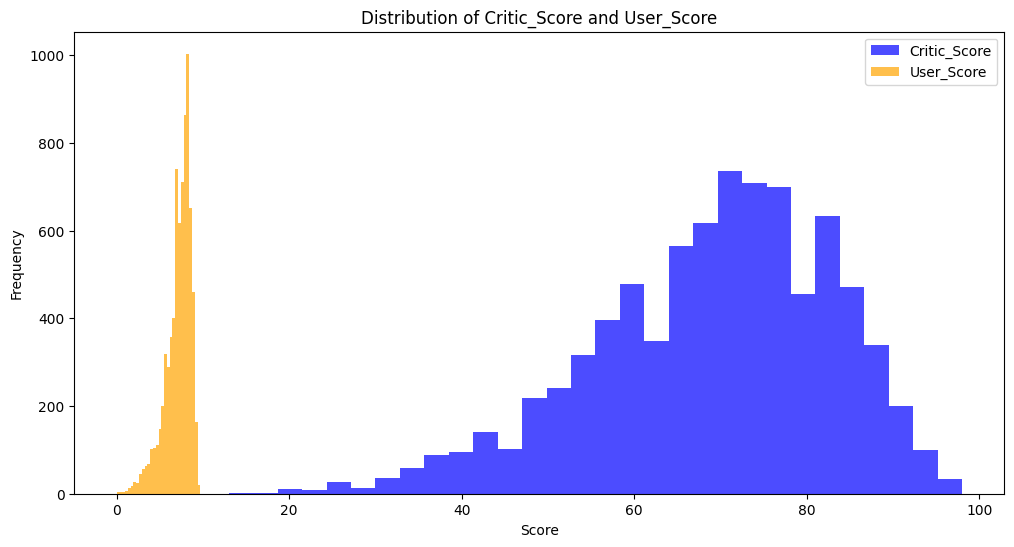

In [271]:
# Visualize the distribution of Critic_Score and User_Score to decide how to fill in the missing values
plt.figure(figsize=(12, 6))
plt.hist(
    df["Critic_Score"].dropna(), bins=30, color="blue", alpha=0.7, label="Critic_Score"
)
plt.hist(
    pd.to_numeric(df["User_Score"], errors="coerce").dropna(),
    bins=30,
    color="orange",
    alpha=0.7,
    label="User_Score",
)
plt.title("Distribution of Critic_Score and User_Score")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.legend()
plt.show()

Based on the distribution of data, using the median would be a good choice. 

In [272]:
# Impute missing `Critic_Score` and `User_Score` with the median
df["Critic_Score"] = df["Critic_Score"].fillna(df["Critic_Score"].median())
df["User_Score"] = pd.to_numeric(
    df["User_Score"], errors="coerce"
)  # Convert "tbd" to NaN
df["User_Score"] = df["User_Score"].fillna(df["User_Score"].median())

# Handle categorical `Rating` by filling with the mode
df["Rating"] = df["Rating"].fillna(df["Rating"].mode()[0])

# Verify changes in the dataset
print("\nDataset info after handling missing values and dropping rows:")
df.info()


Dataset info after handling missing values and dropping rows:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16719 entries, 0 to 16718
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16717 non-null  object 
 1   Platform         16719 non-null  object 
 2   Year_of_Release  16450 non-null  float64
 3   Genre            16717 non-null  object 
 4   Publisher        16665 non-null  object 
 5   NA_Sales         16719 non-null  float64
 6   EU_Sales         16719 non-null  float64
 7   JP_Sales         16719 non-null  float64
 8   Other_Sales      16719 non-null  float64
 9   Global_Sales     16719 non-null  float64
 10  Critic_Score     16719 non-null  float64
 11  Critic_Count     8137 non-null   float64
 12  User_Score       16719 non-null  float64
 13  User_Count       7590 non-null   float64
 14  Developer        10096 non-null  object 
 15  Rating           16719 non-null  object 


In [273]:
# Drop all rows with any missing values
df.dropna(inplace=True)

# Verify the dataset after dropping rows
print("\nDataset info after removing all rows with any missing values:")
df.info()


Dataset info after removing all rows with any missing values:
<class 'pandas.core.frame.DataFrame'>
Index: 6889 entries, 0 to 16709
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             6889 non-null   object 
 1   Platform         6889 non-null   object 
 2   Year_of_Release  6889 non-null   float64
 3   Genre            6889 non-null   object 
 4   Publisher        6889 non-null   object 
 5   NA_Sales         6889 non-null   float64
 6   EU_Sales         6889 non-null   float64
 7   JP_Sales         6889 non-null   float64
 8   Other_Sales      6889 non-null   float64
 9   Global_Sales     6889 non-null   float64
 10  Critic_Score     6889 non-null   float64
 11  Critic_Count     6889 non-null   float64
 12  User_Score       6889 non-null   float64
 13  User_Count       6889 non-null   float64
 14  Developer        6889 non-null   object 
 15  Rating           6889 non-null   object 
dtypes

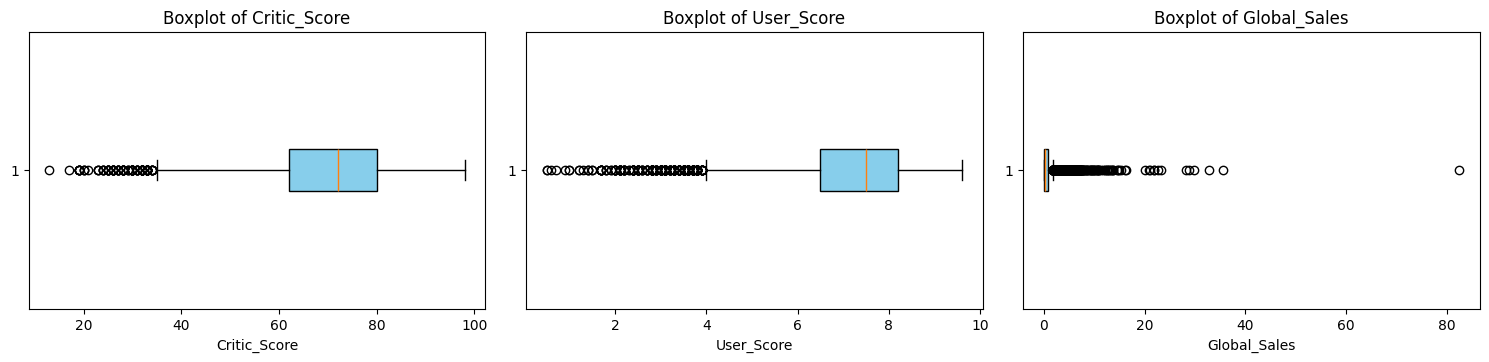

(6889, 16)

In [274]:
# List of numerical columns to check for outliers
numerical_columns = ["Critic_Score", "User_Score", "Global_Sales"]

# Generate boxplots for each numerical column
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_columns, start=1):
    if col in df.columns:
        plt.subplot(3, 3, i)  # Create subplots (3 rows x 3 columns for 9 plots)
        plt.boxplot(
            df[col].dropna(),
            vert=False,
            patch_artist=True,
            boxprops=dict(facecolor="skyblue"),
        )
        plt.title(f"Boxplot of {col}")
        plt.xlabel(col)
plt.tight_layout()
plt.show()
df.shape

In [275]:
# Remove outliers for Critic_Score
df = df[(df["Critic_Score"] >= 20) & (df["Critic_Score"] <= 100)]

# Remove outliers for Global_Sales
df = df[df["Global_Sales"] <= 80]

df.shape

(6880, 16)

# Data Exploration 

## We are going to compare different features to global sales in order to see which ones are more relevant to predicting how well a game will sell globally 

In [276]:
# Scatter Plot Shows the relationship between Critic Score and Global Sales

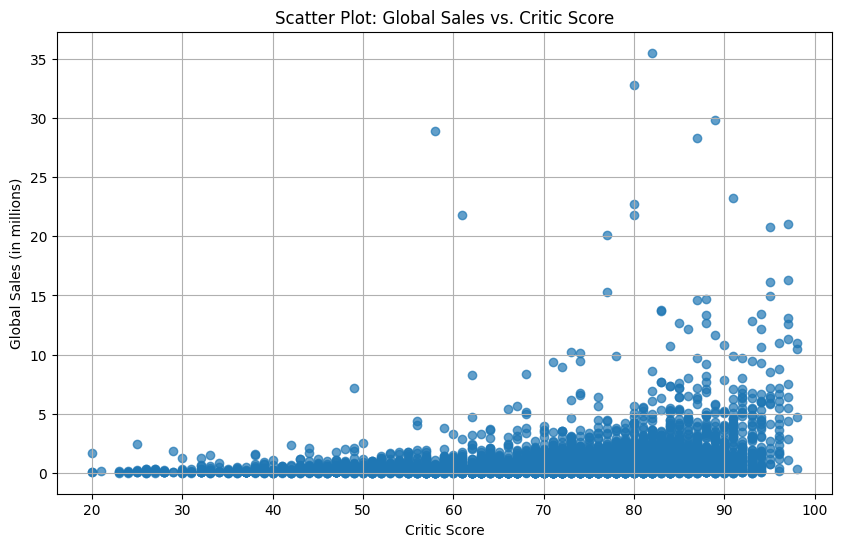

In [277]:
plt.figure(figsize=(10, 6))
plt.scatter(df["Critic_Score"], df["Global_Sales"], alpha=0.7)
plt.title("Scatter Plot: Global Sales vs. Critic Score")
plt.xlabel("Critic Score")
plt.ylabel("Global Sales (in millions)")
plt.grid(True)
plt.show()

In [278]:
# Line Plot: Highlights trends in Global Sales as Critic Scores change.

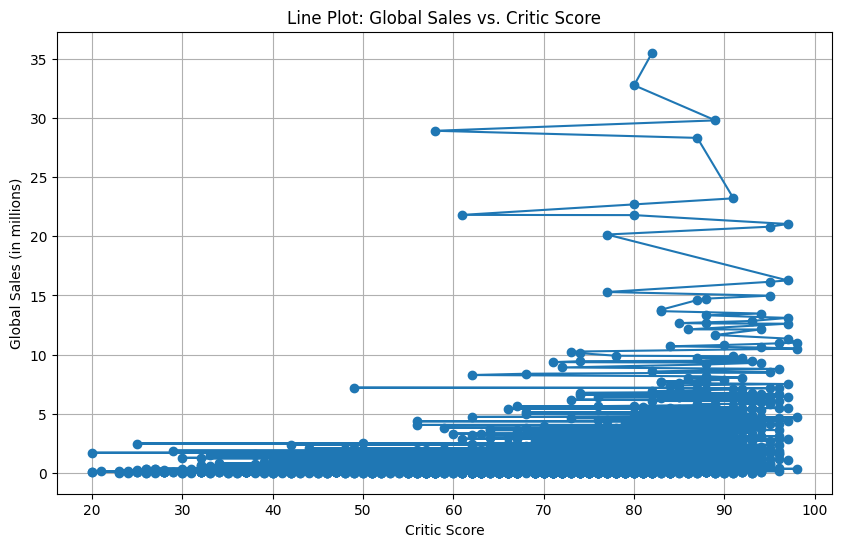

In [279]:
plt.figure(figsize=(10, 6))
plt.plot(df["Critic_Score"], df["Global_Sales"], marker="o")
plt.title("Line Plot: Global Sales vs. Critic Score")
plt.xlabel("Critic Score")
plt.ylabel("Global Sales (in millions)")
plt.grid(True)
plt.show()

In [280]:
# BarPlot: Compares Global Sales for each Critic Score.

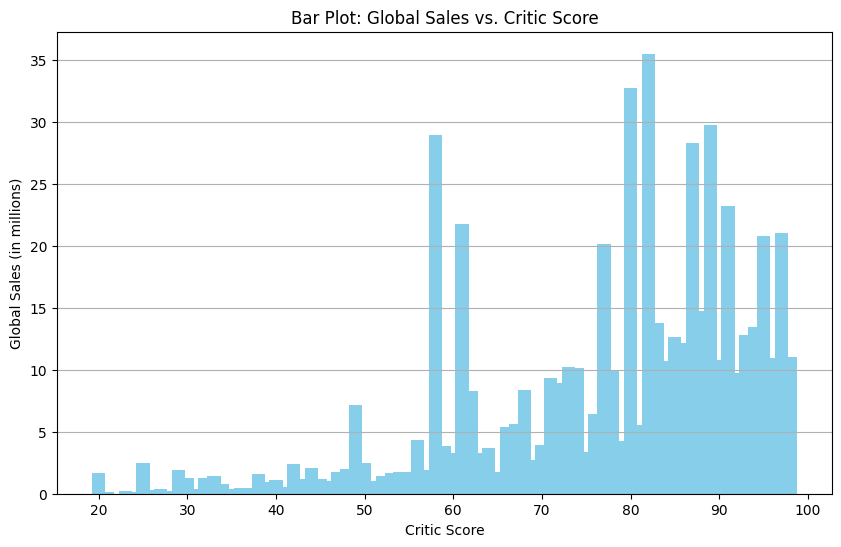

In [281]:
plt.figure(figsize=(10, 6))
plt.bar(df["Critic_Score"], df["Global_Sales"], color="skyblue", width=1.5)
plt.title("Bar Plot: Global Sales vs. Critic Score")
plt.xlabel("Critic Score")
plt.ylabel("Global Sales (in millions)")
plt.grid(axis="y")
plt.show()

In [282]:
#We will do the same for user score 

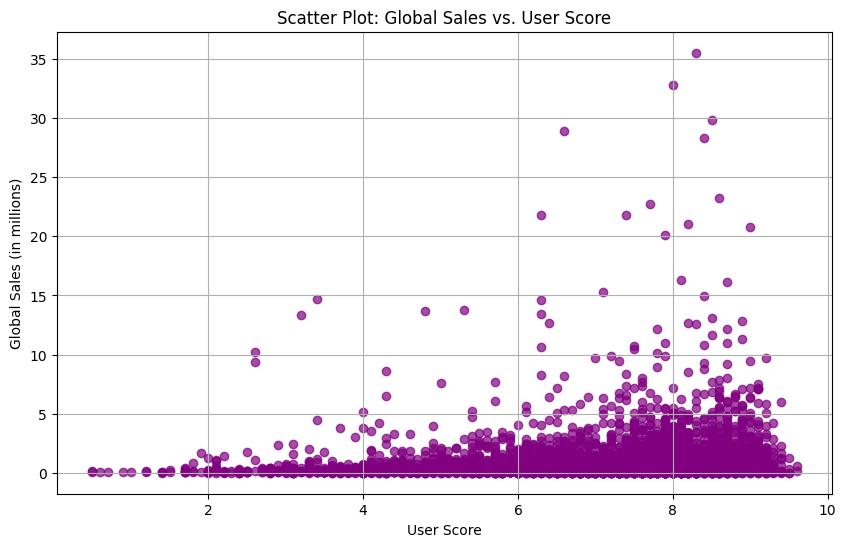

In [283]:
plt.figure(figsize=(10, 6))
plt.scatter(df['User_Score'], df['Global_Sales'], alpha=0.7, color='purple')
plt.title('Scatter Plot: Global Sales vs. User Score')
plt.xlabel('User Score')
plt.ylabel('Global Sales (in millions)')
plt.grid(True)
plt.show()

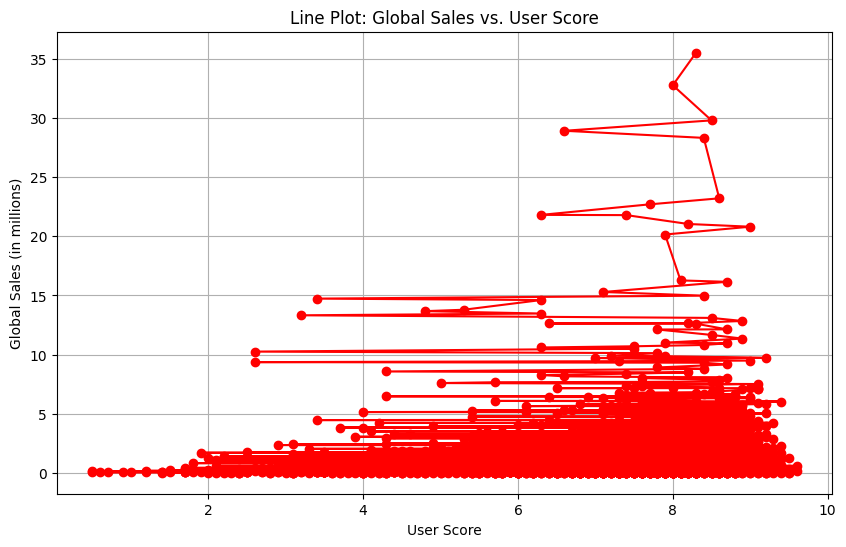

In [284]:
plt.figure(figsize=(10, 6))
plt.plot(df["User_Score"], df["Global_Sales"], marker="o", color="red")
plt.title("Line Plot: Global Sales vs. User Score")
plt.xlabel("User Score")
plt.ylabel("Global Sales (in millions)")
plt.grid(True)
plt.show()

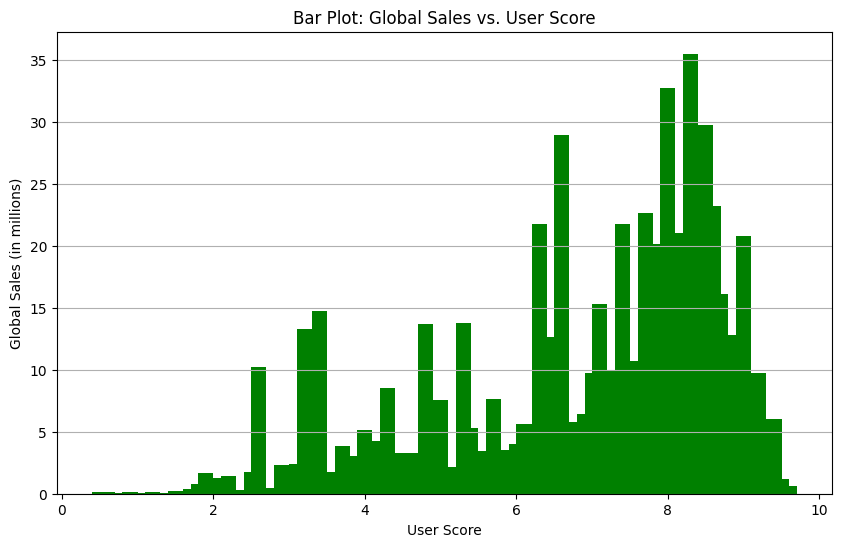

In [285]:
plt.figure(figsize=(10, 6))
plt.bar(df["User_Score"], df["Global_Sales"], color="green", width=0.2)
plt.title("Bar Plot: Global Sales vs. User Score")
plt.xlabel("User Score")
plt.ylabel("Global Sales (in millions)")
plt.grid(axis="y")
plt.show()

In [286]:
df.describe()

,Year_of_Release,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count
count,6880.000000,6880.000000,6880.000000,6880.000000,6880.000000,6880.000000,6880.000000,6880.000000,6880.000000,6880.000000
mean,2007.479651,0.385561,0.230727,0.063449,0.080923,0.760843,70.328343,28.874855,7.190872,174.506105
std,4.237106,0.827937,0.590808,0.283236,0.249224,1.690054,13.749114,19.191627,1.430490,585.426452
min,1985.000000,0.000000,0.000000,0.000000,0.000000,0.010000,20.000000,3.000000,0.500000,4.000000
25%,2004.000000,0.060000,0.020000,0.000000,0.010000,0.110000,62.000000,14.000000,6.500000,11.000000
50%,2007.000000,0.150000,0.060000,0.000000,0.020000,0.290000,72.000000,24.000000,7.500000,27.000000
75%,2011.000000,0.390000,0.210000,0.010000,0.070000,0.750000,80.000000,39.000000,8.200000,89.000000
max,2016.000000,15.680000,12.760000,6.500000,10.570000,35.520000,98.000000,113.000000,9.600000,10665.000000


In [287]:
# List of categorical columns
categorical_columns = ["Name", "Platform", "Genre", "Publisher", "Developer", "Rating"]

# Value counts for each categorical column
for col in categorical_columns:
    print(f"\nValue counts for {col}:")
    print(df[col].value_counts())


Value counts for Name:
Name
LEGO Star Wars II: The Original Trilogy                  8
Need for Speed: Most Wanted                              8
Madden NFL 07                                            8
Need for Speed: ProStreet                                7
The Sims 2                                               7
                                                        ..
Madden NFL Football                                      1
Donkey Konga 2                                           1
Combat of Giants: Dinosaurs 3D                           1
Final Fantasy Crystal Chronicles: The Crystal Bearers    1
15 Days                                                  1
Name: count, Length: 4421, dtype: int64

Value counts for Platform:
Platform
PS2     1140
X360     859
PS3      772
PC       686
XB       564
Wii      477
DS       464
PSP      390
GC       348
PS4      248
GBA      237
XOne     165
3DS      156
PS       153
PSV      118
WiiU      89
DC        14
Name: count, dtype: int6

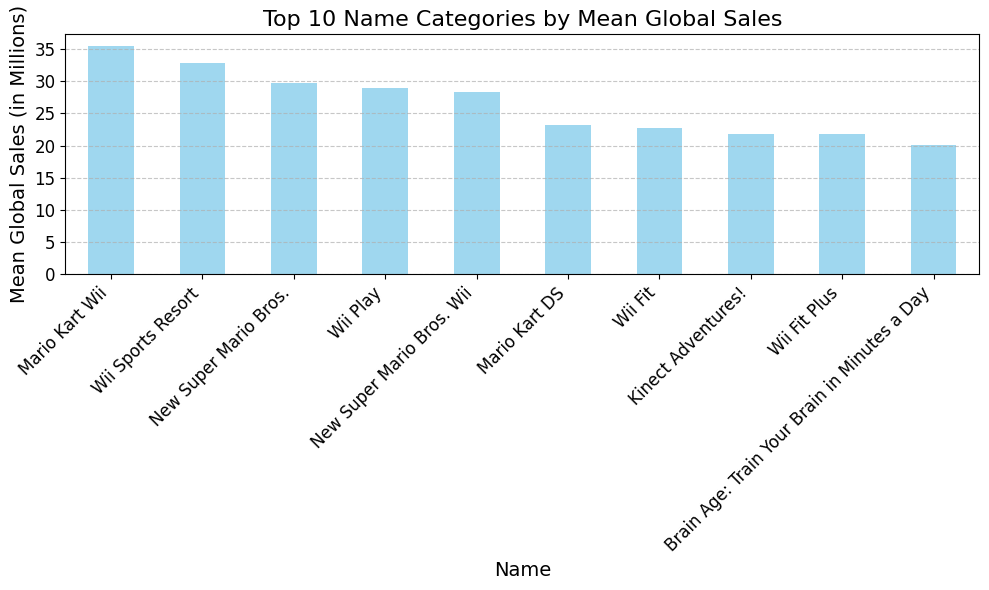

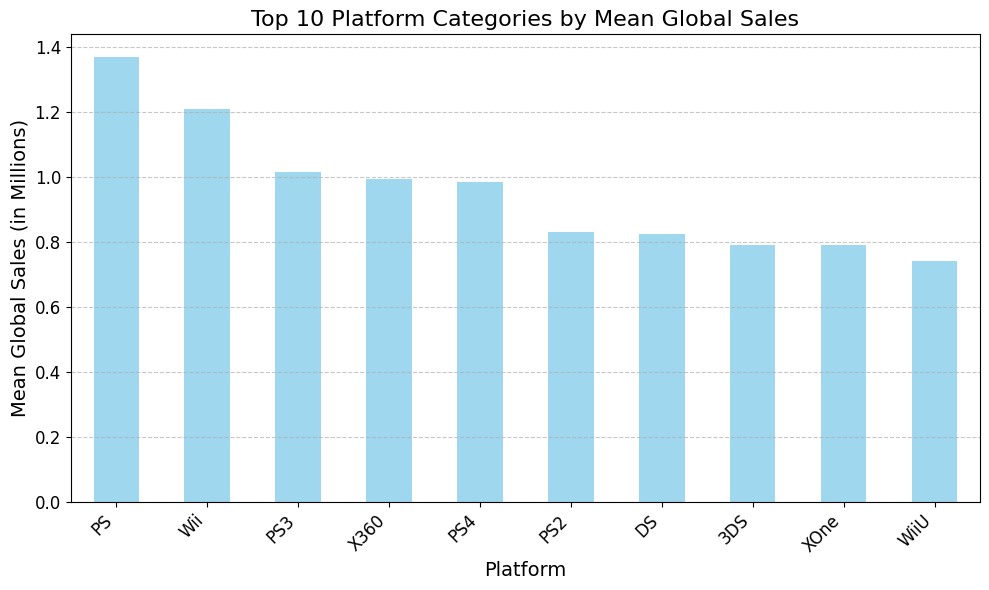

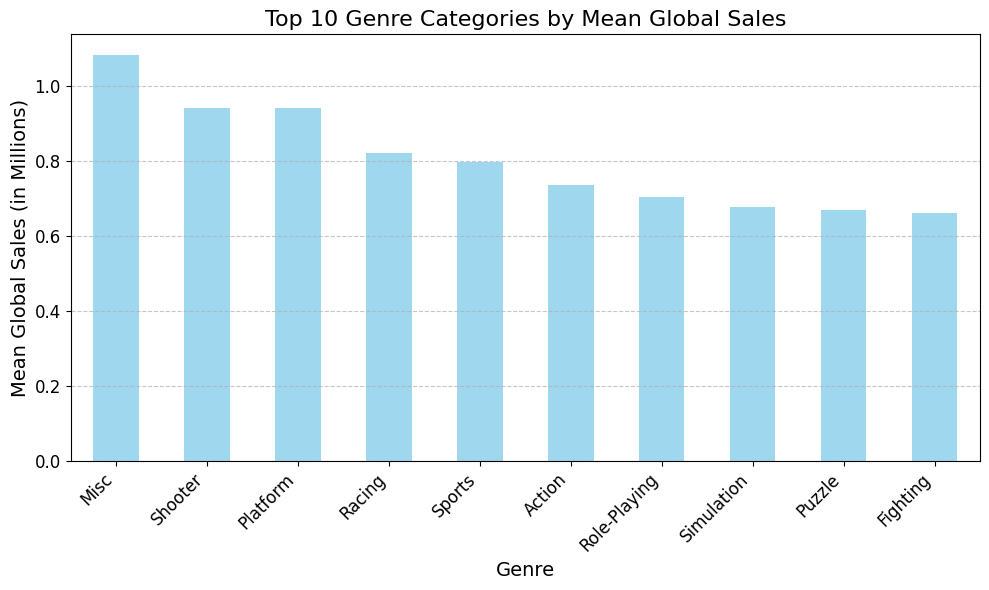

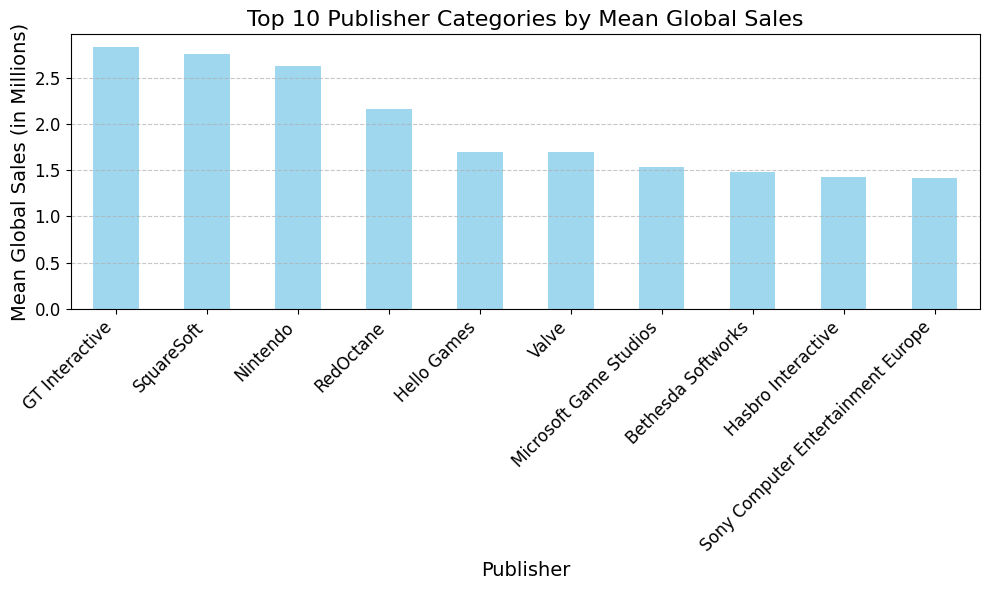

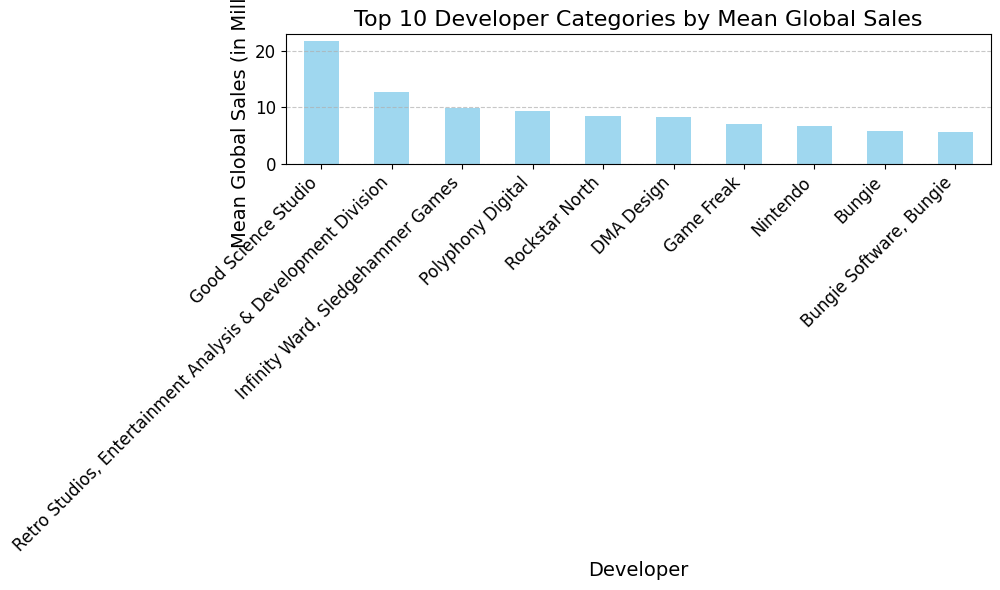

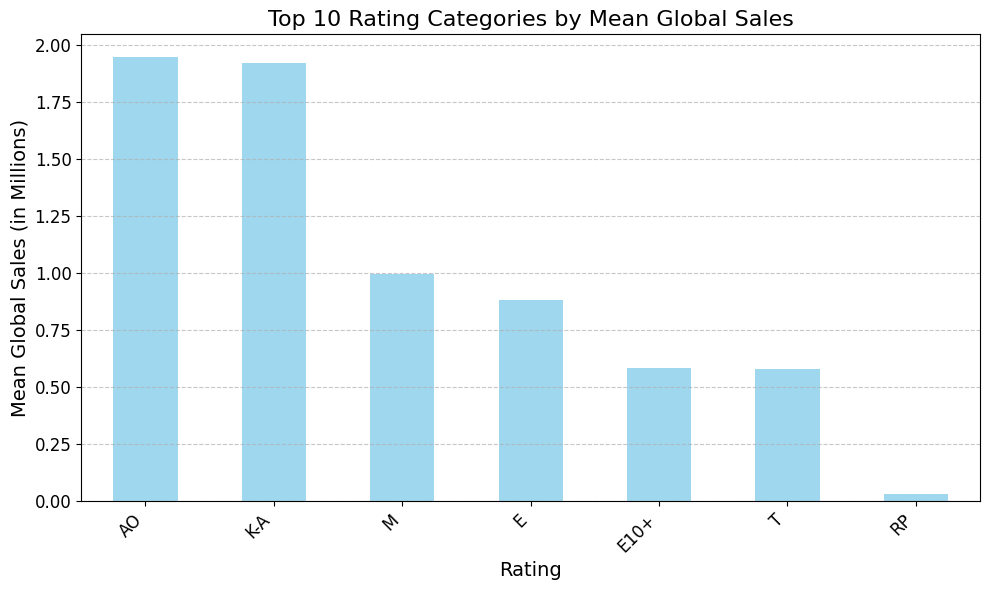

In [288]:
# Visualize the impact of categorical columns on Global_Sales
for col in categorical_columns:
    plt.figure(figsize=(10, 6))
    df.groupby(col)["Global_Sales"].mean().sort_values(ascending=False).head(10).plot(
        kind="bar", color="skyblue", alpha=0.8
    )
    plt.title(f"Top 10 {col} Categories by Mean Global Sales", fontsize=16)
    plt.xlabel(col, fontsize=14)
    plt.ylabel("Mean Global Sales (in Millions)", fontsize=14)
    plt.xticks(rotation=45, ha="right", fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()

In [289]:
# List of numerical columns
numerical_columns = [
    "Year_of_Release",
    "NA_Sales",
    "EU_Sales",
    "JP_Sales",
    "Other_Sales",
    "Critic_Score",
    "Critic_Count",
    "User_Score",
    "User_Count",
]
# Descriptive statistics for numerical columns
print("\nSummary statistics for numerical columns:")
print(df[numerical_columns].describe())


Summary statistics for numerical columns:
       Year_of_Release     NA_Sales     EU_Sales     JP_Sales  Other_Sales  \
count      6880.000000  6880.000000  6880.000000  6880.000000  6880.000000   
mean       2007.479651     0.385561     0.230727     0.063449     0.080923   
std           4.237106     0.827937     0.590808     0.283236     0.249224   
min        1985.000000     0.000000     0.000000     0.000000     0.000000   
25%        2004.000000     0.060000     0.020000     0.000000     0.010000   
50%        2007.000000     0.150000     0.060000     0.000000     0.020000   
75%        2011.000000     0.390000     0.210000     0.010000     0.070000   
max        2016.000000    15.680000    12.760000     6.500000    10.570000   

       Critic_Score  Critic_Count   User_Score    User_Count  
count   6880.000000   6880.000000  6880.000000   6880.000000  
mean      70.328343     28.874855     7.190872    174.506105  
std       13.749114     19.191627     1.430490    585.426452  
mi

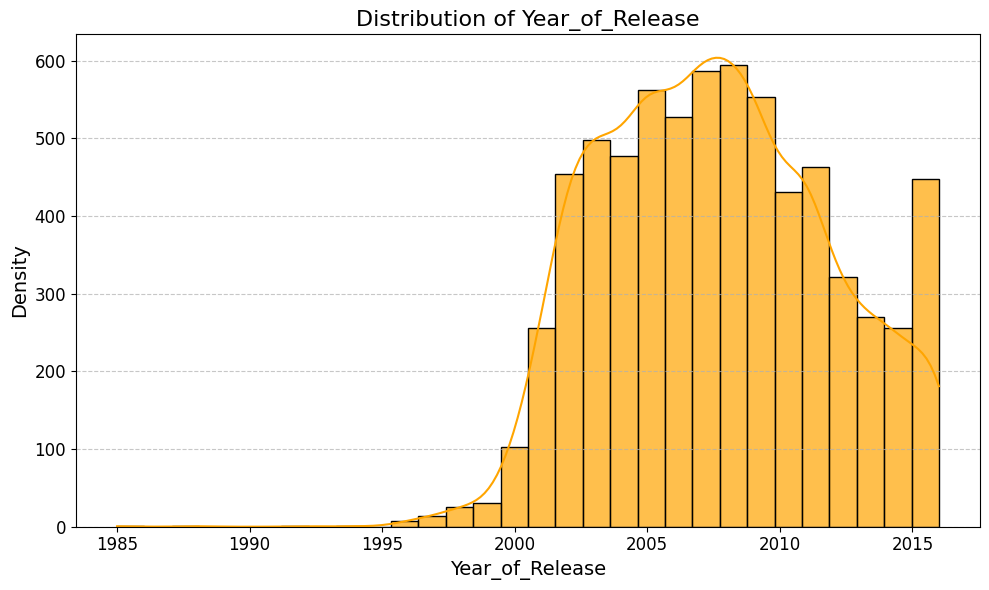

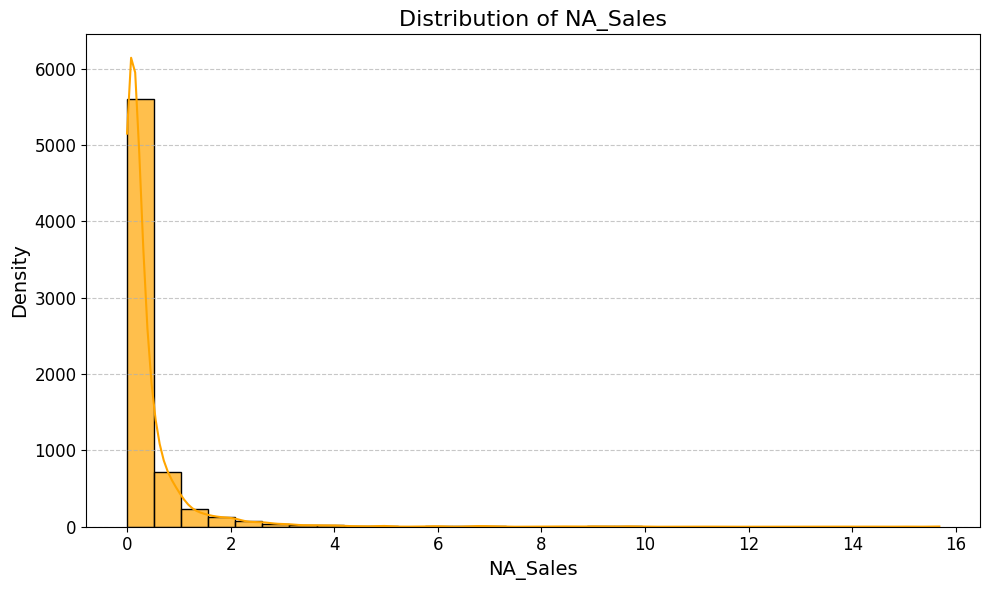

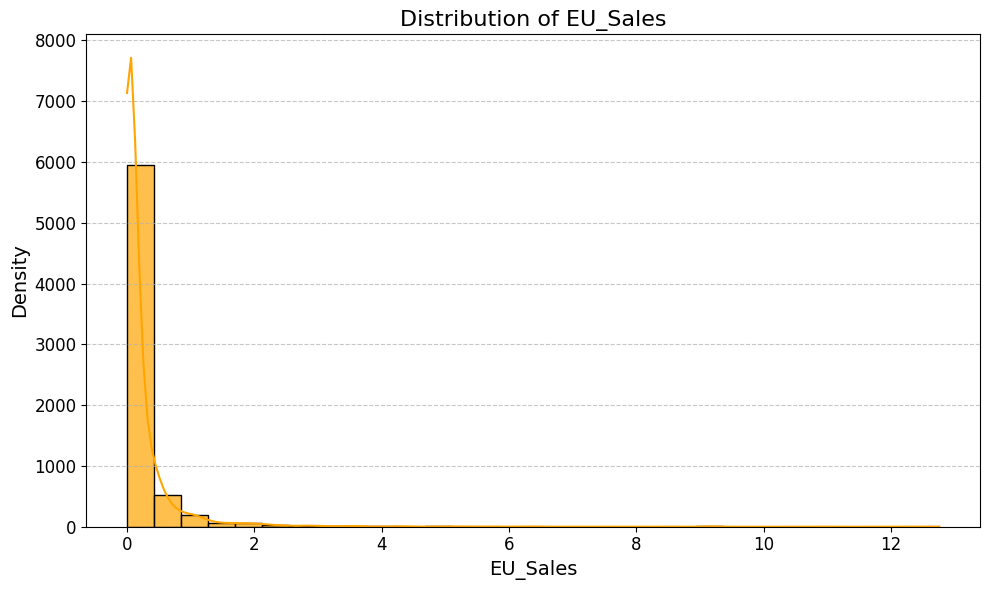

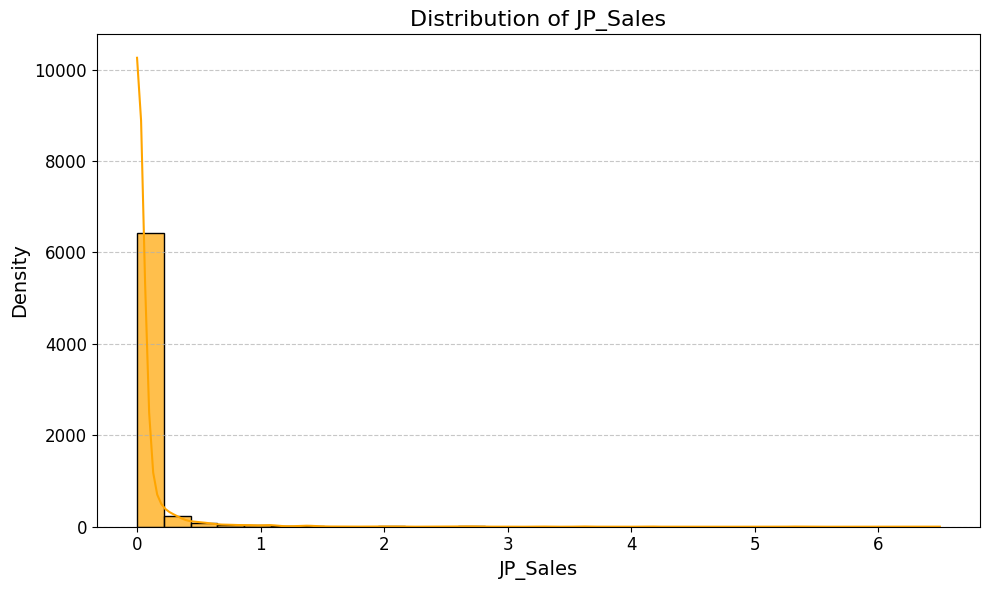

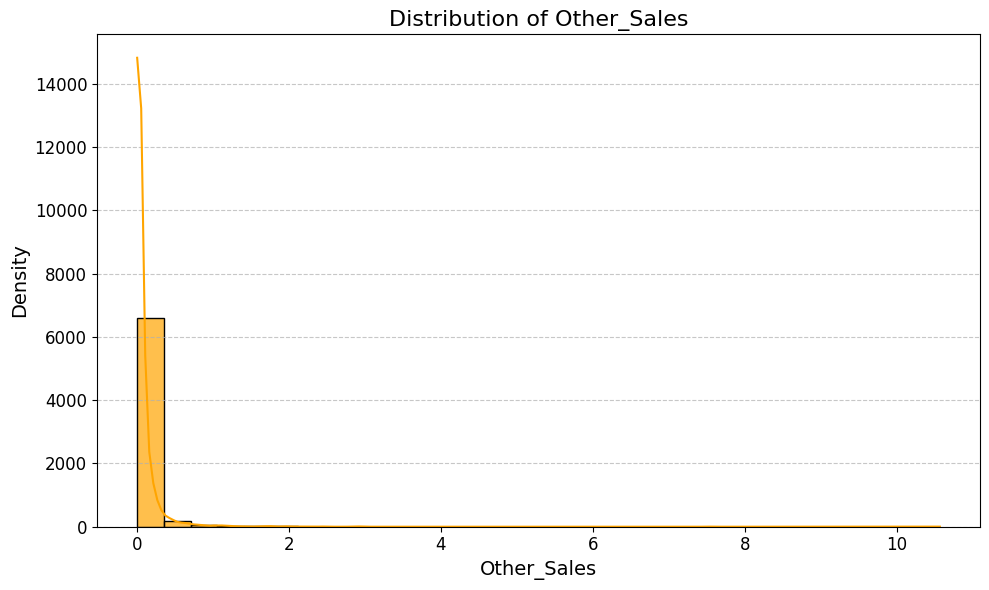

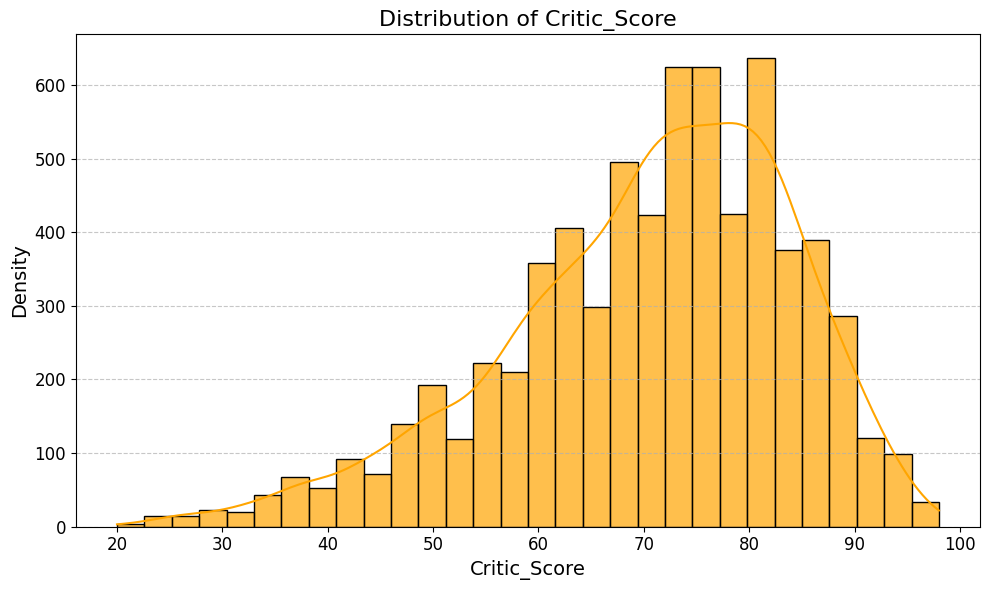

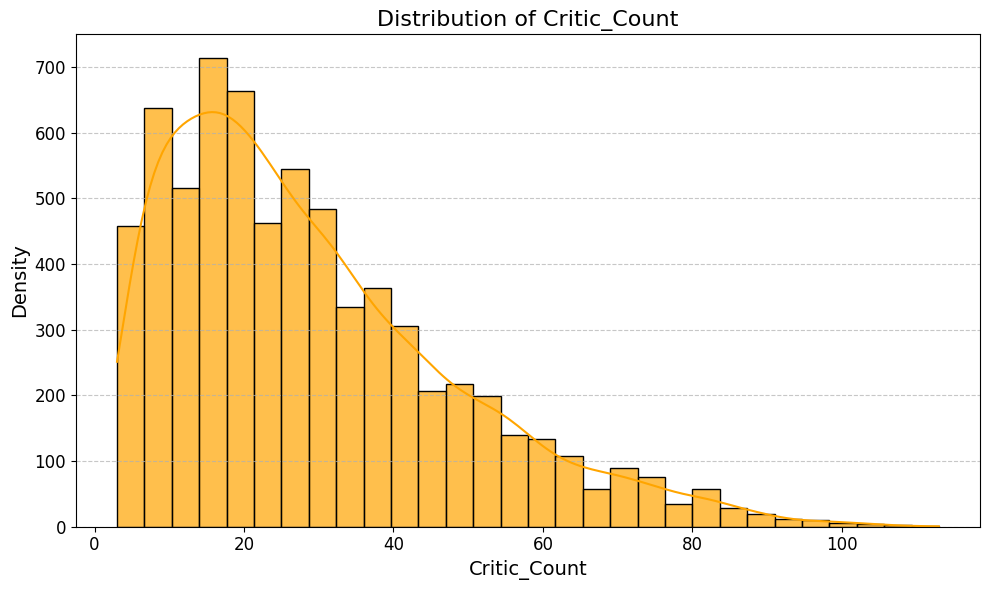

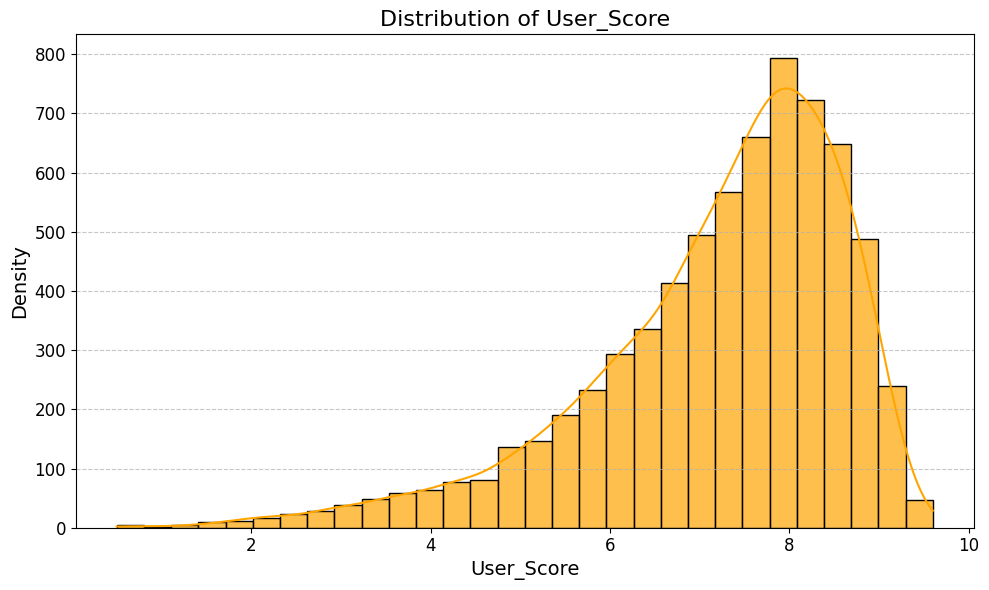

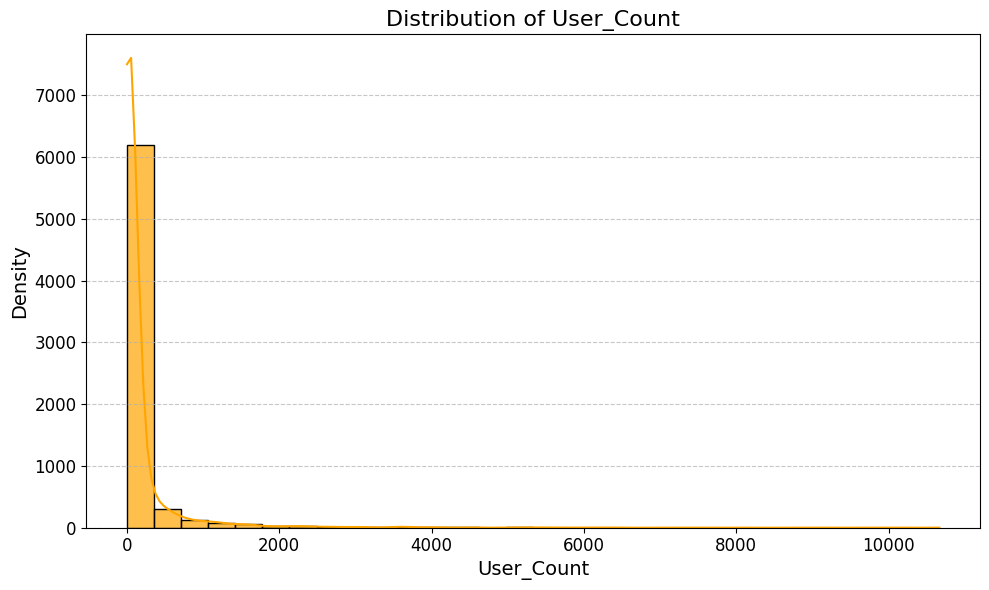

In [290]:
# Visualize distributions of numerical columns using histplot
for col in numerical_columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(df[col], kde=True, bins=30, color="orange", alpha=0.7)
    plt.title(f"Distribution of {col}", fontsize=16)
    plt.xlabel(col, fontsize=14)
    plt.ylabel("Density", fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()

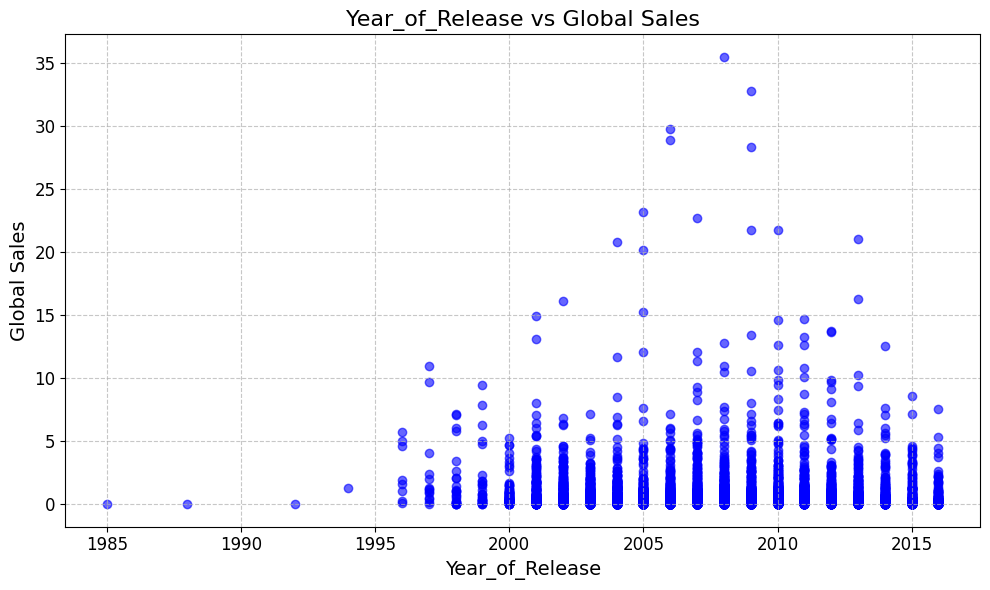

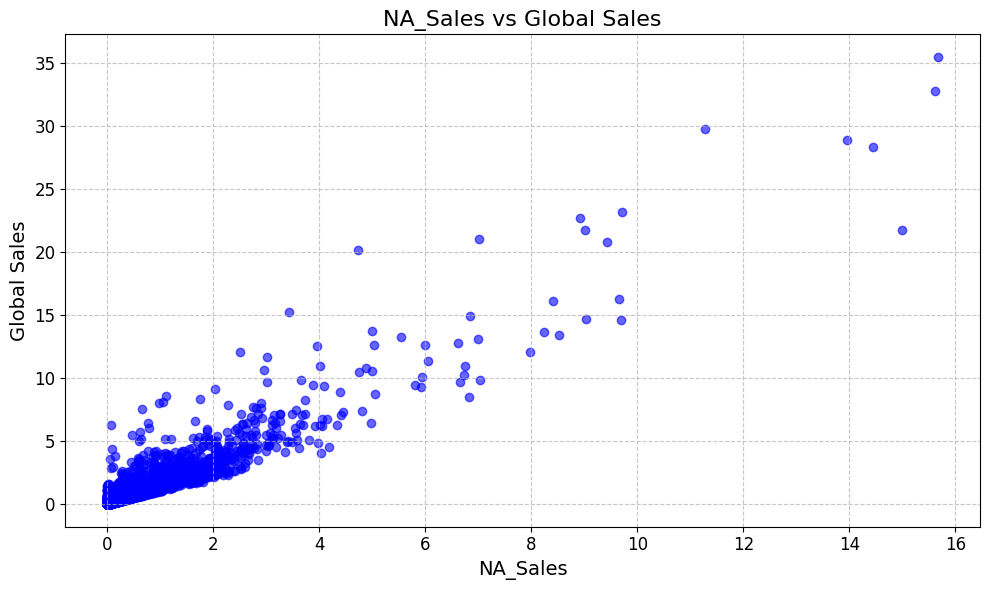

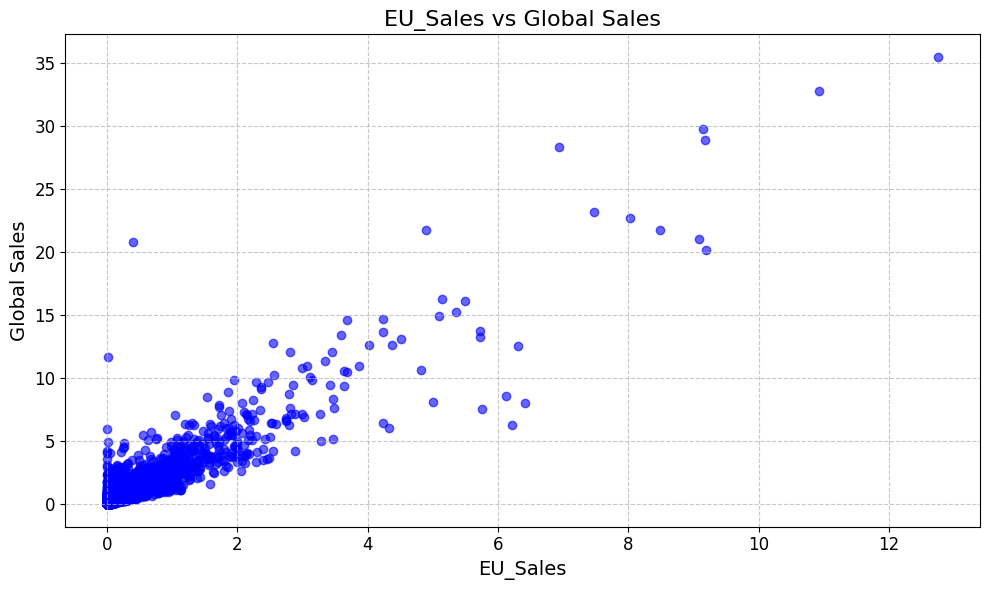

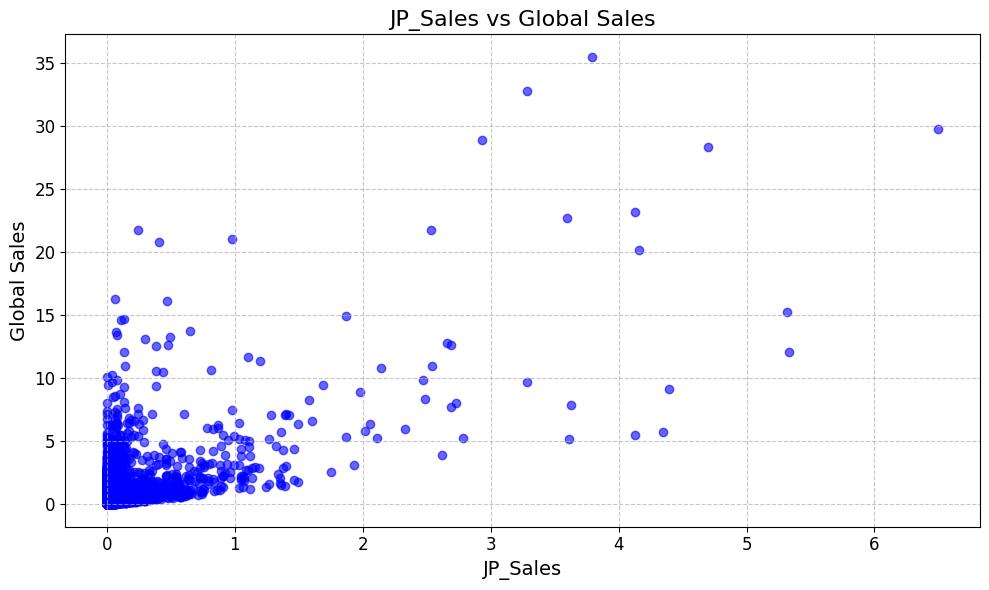

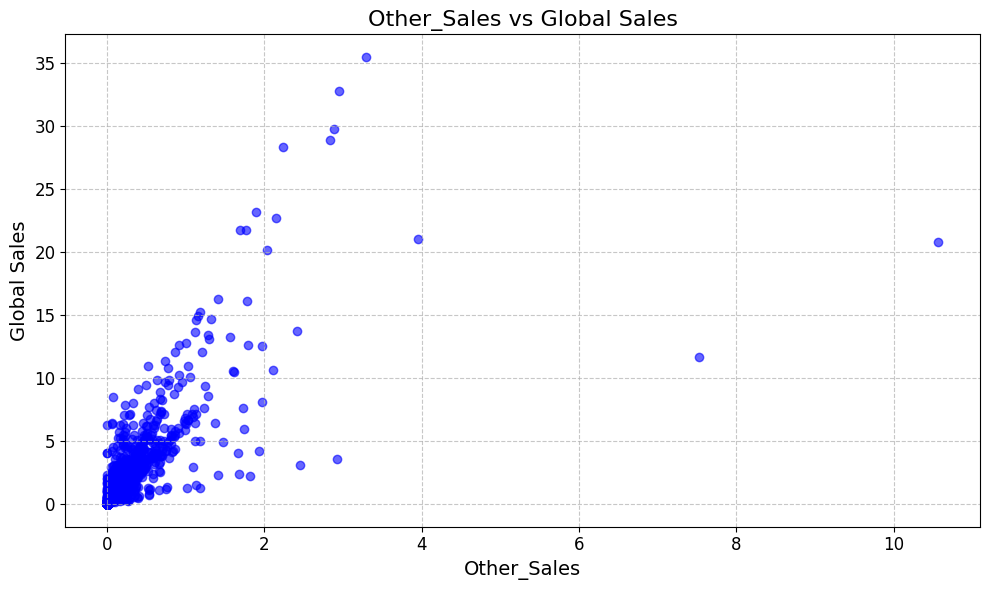

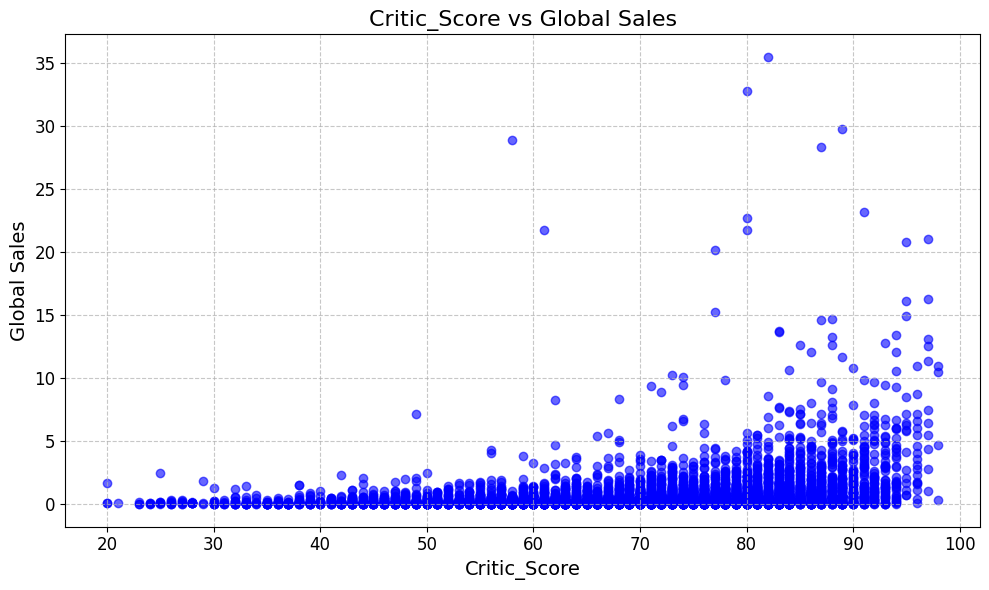

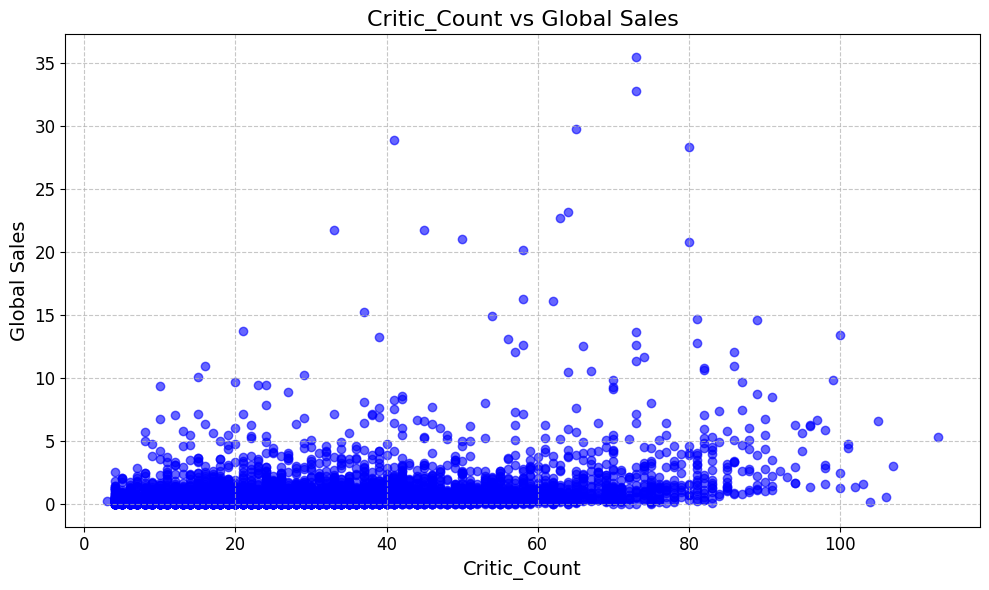

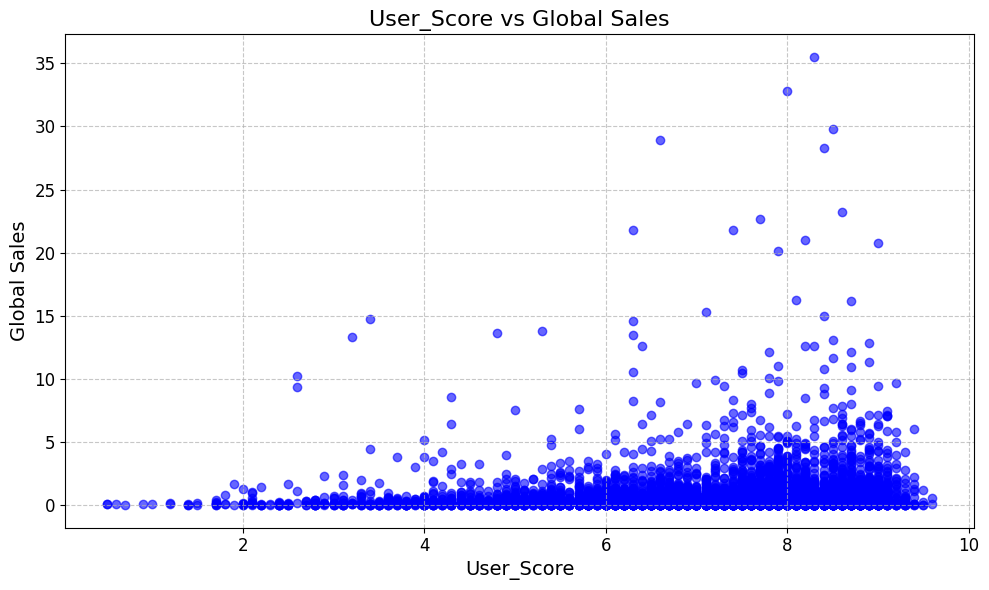

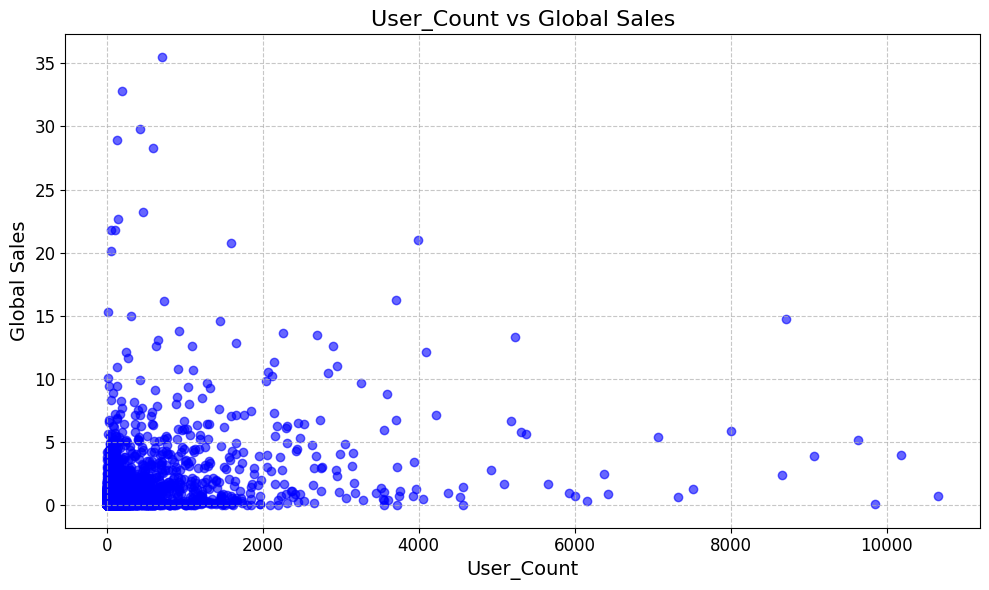

In [291]:
# Compare each numerical column to Global_Sales using scatter plots
for col in numerical_columns:
    plt.figure(figsize=(10, 6))
    plt.scatter(df[col], df["Global_Sales"], alpha=0.6, color="blue")
    plt.title(f"{col} vs Global Sales", fontsize=16)
    plt.xlabel(col, fontsize=14)
    plt.ylabel("Global Sales", fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(axis="both", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()

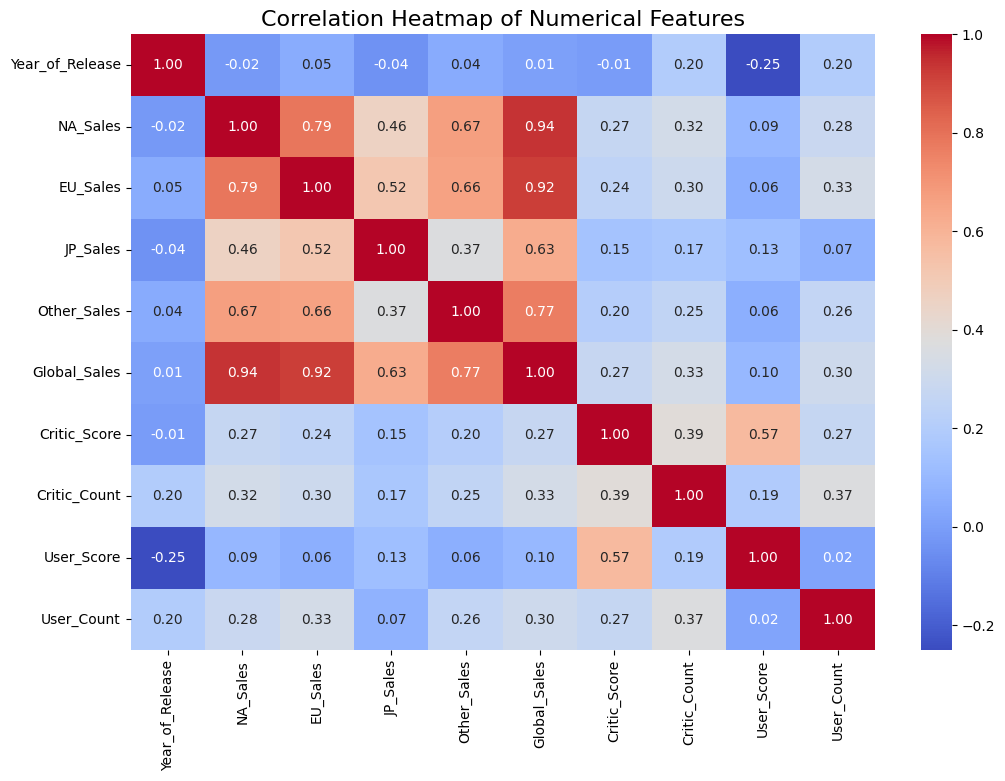

In [292]:
# Select only numerical columns
numerical_data = df.select_dtypes(include=["float64", "int64"])

# Compute correlation matrix
cor = numerical_data.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    cor,
    xticklabels=cor.columns,
    yticklabels=cor.columns,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
)
plt.title("Correlation Heatmap of Numerical Features", fontsize=16)
plt.show()

In [293]:
lower_quartile_critic_count = df["Critic_Count"].describe()["25%"]
lower_quartile_user_count = df["User_Count"].describe()["25%"]

df = df[df["Critic_Count"] >= lower_quartile_critic_count]
df = df[df["User_Count"] >= lower_quartile_user_count]

print(df.shape)

(4424, 16)


In [294]:
print('df["Platform"].unique():', df["Platform"].unique())
print('df["Genre"].unique():', df["Genre"].unique())
print('df["Publisher"].unique():', df["Publisher"].unique().__len__())
print('df["Developer"].unique():', df["Developer"].unique())
print('df["Rating"].unique():', df["Rating"].unique())

df = pd.get_dummies(df, columns=["Platform", "Genre", "Rating"])
# df.head()

# rating AO - 1
# rating K-A - 1

df["Platform"].unique(): ['Wii' 'DS' 'X360' 'PS3' 'PS2' '3DS' 'PS4' 'PS' 'XB' 'PC' 'PSP' 'WiiU'
 'GC' 'GBA' 'XOne' 'PSV' 'DC']
df["Genre"].unique(): ['Racing' 'Sports' 'Platform' 'Misc' 'Action' 'Puzzle' 'Shooter'
 'Fighting' 'Simulation' 'Role-Playing' 'Adventure' 'Strategy']
df["Publisher"].unique(): 192
df["Developer"].unique(): ['Nintendo' 'Good Science Studio' 'Rockstar North' 'Polyphony Digital'
 'Infinity Ward, Sledgehammer Games' 'Treyarch' 'Infinity Ward'
 'DMA Design' 'Game Arts'
 'Retro Studios, Entertainment Analysis & Development Division'
 'Bungie Software, Bungie' 'Ubisoft' 'Bungie' 'SquareSoft'
 '343 Industries' 'Hudson Soft' 'Bethesda Game Studios' 'EA Sports'
 'Bungie Software' 'Nd Cube' 'Hudson' 'Electronic Arts' 'The Sims Studio'
 'Game Freak' 'Rockstar Leeds' 'Sledgehammer Games'
 'EA Sports, EA Vancouver' 'Nintendo EAD Tokyo' 'EA DICE' 'EA Black Box'
 'Ubisoft Paris' 'Namco' 'HAL Labs' 'EA Canada' 'EA LA' 'Epic Games'
 'Naughty Dog' 'Rockstar San Diego' 'Retro Stu

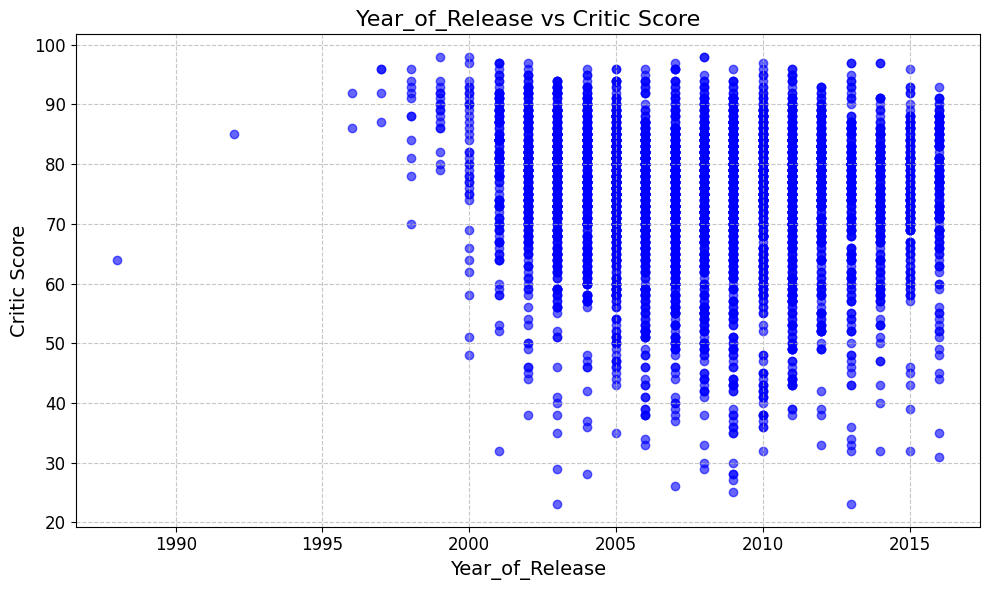

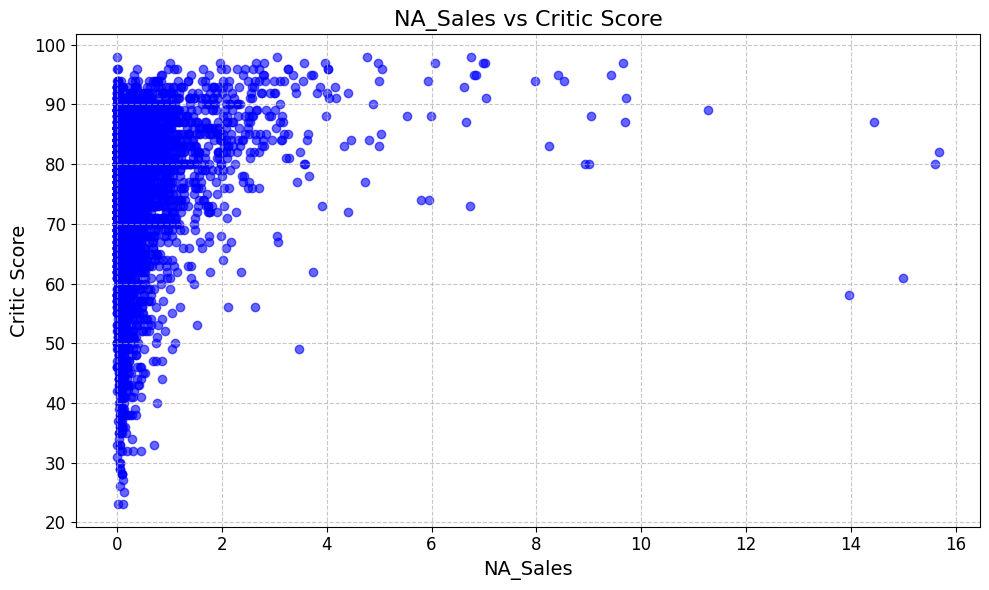

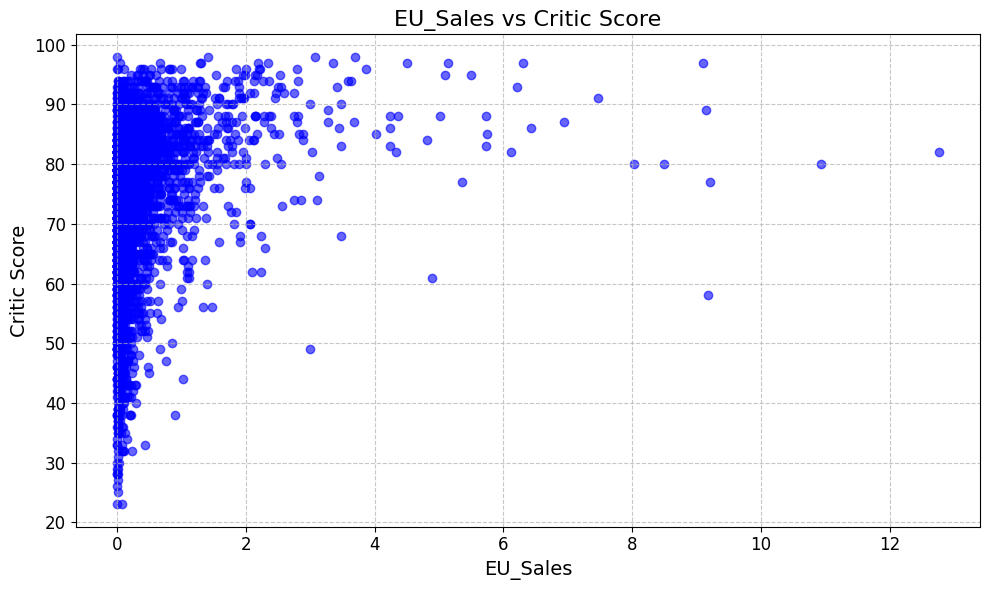

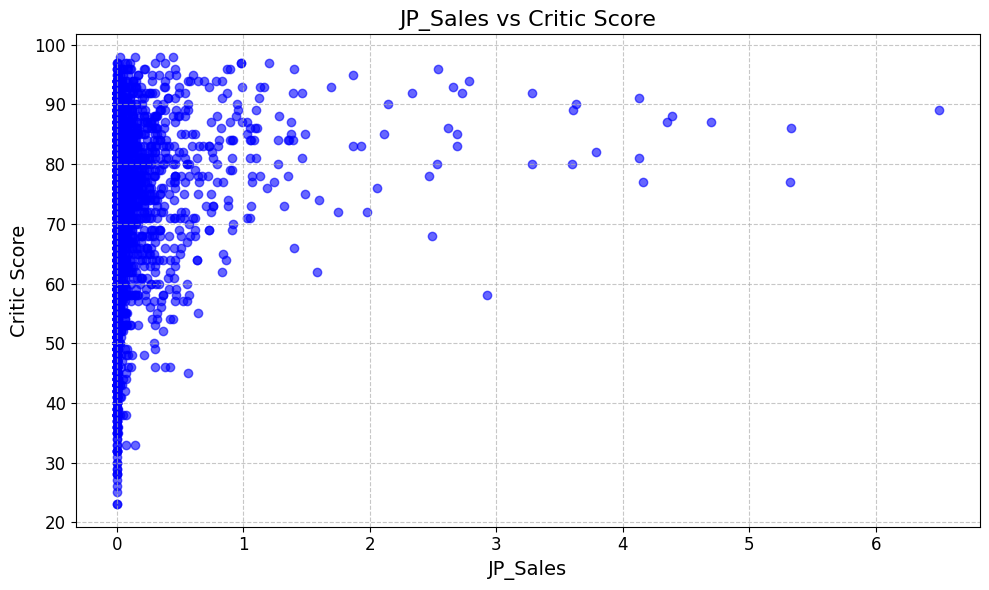

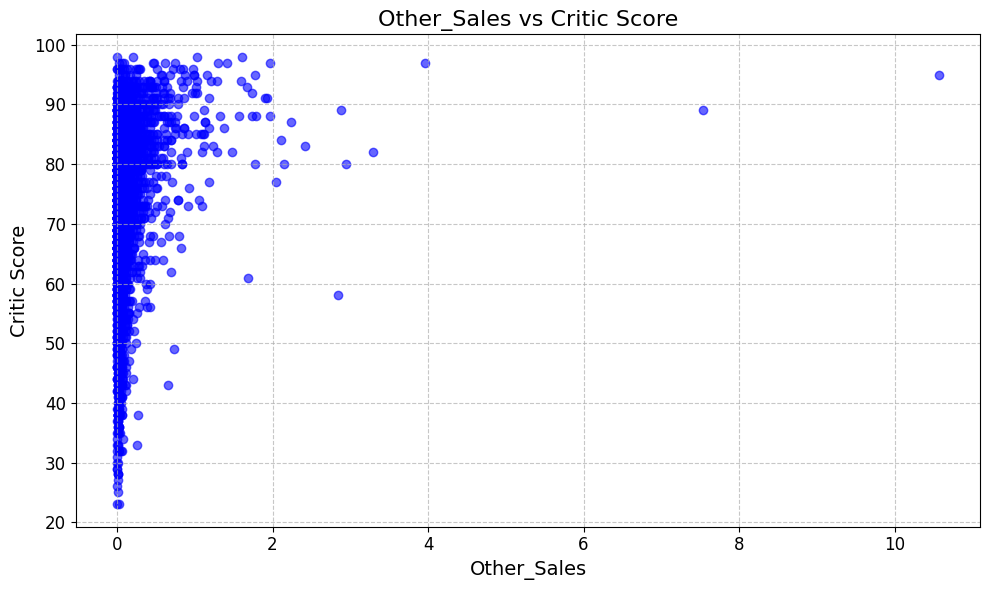

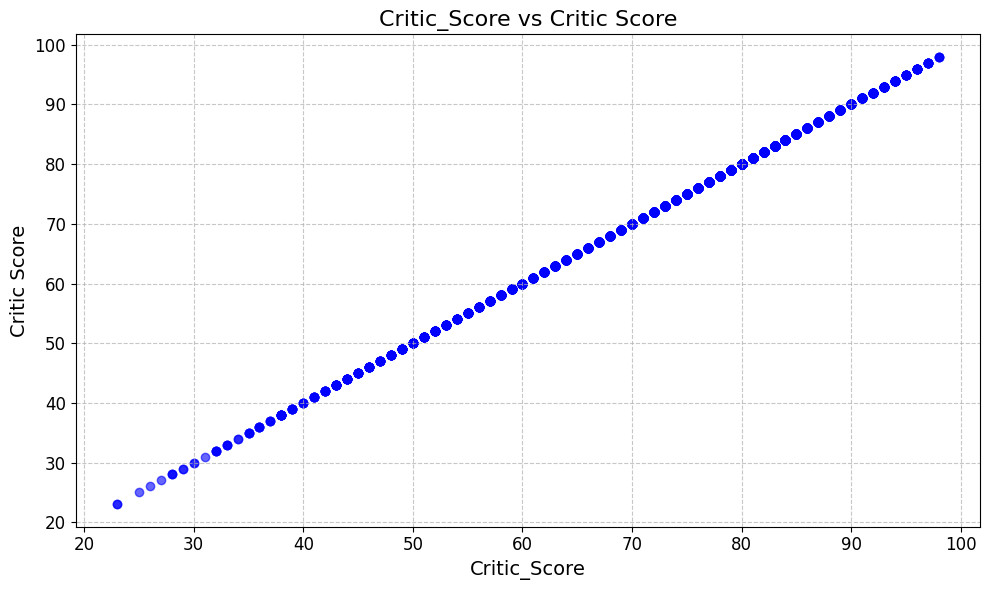

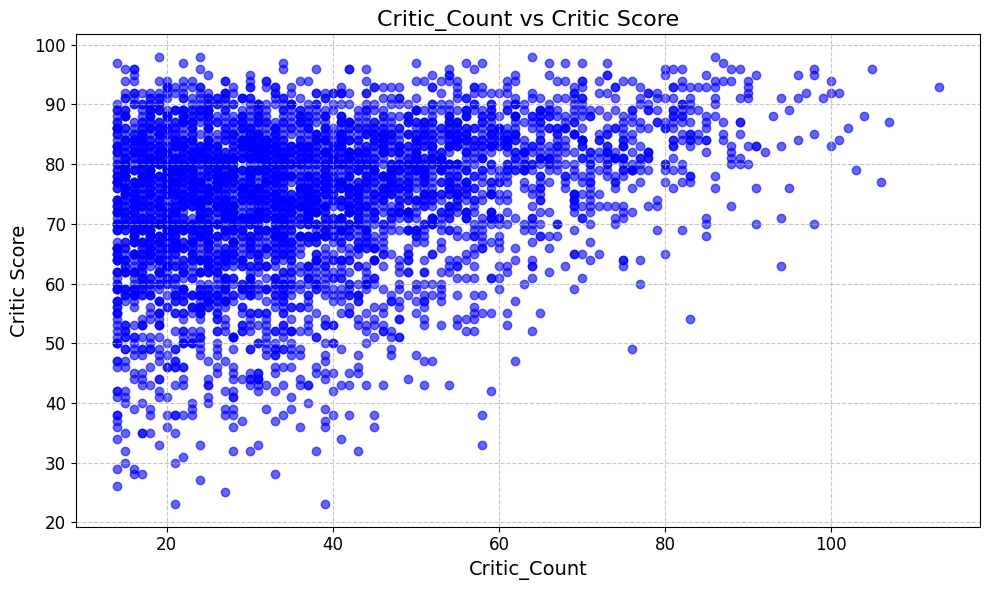

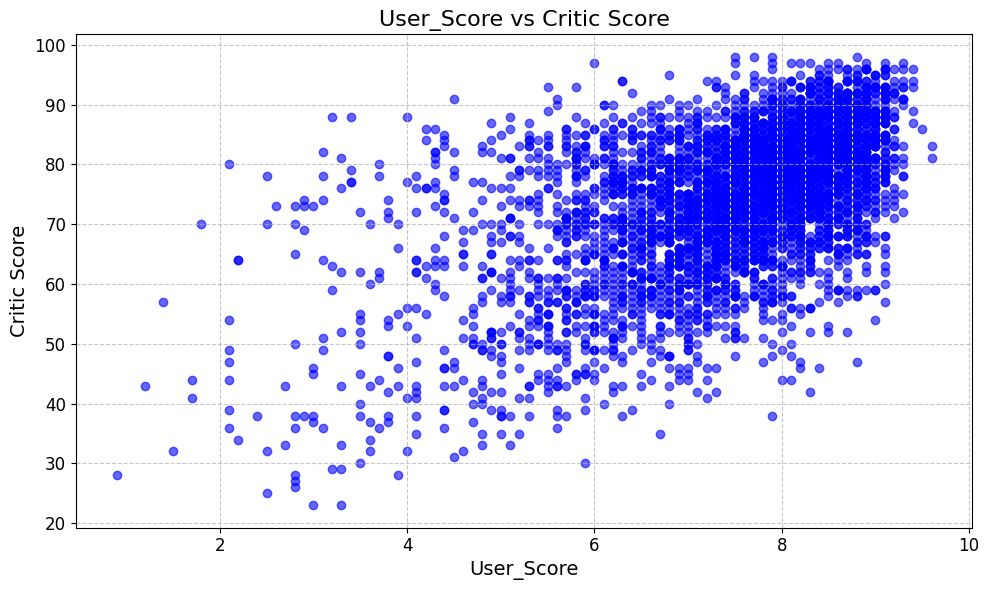

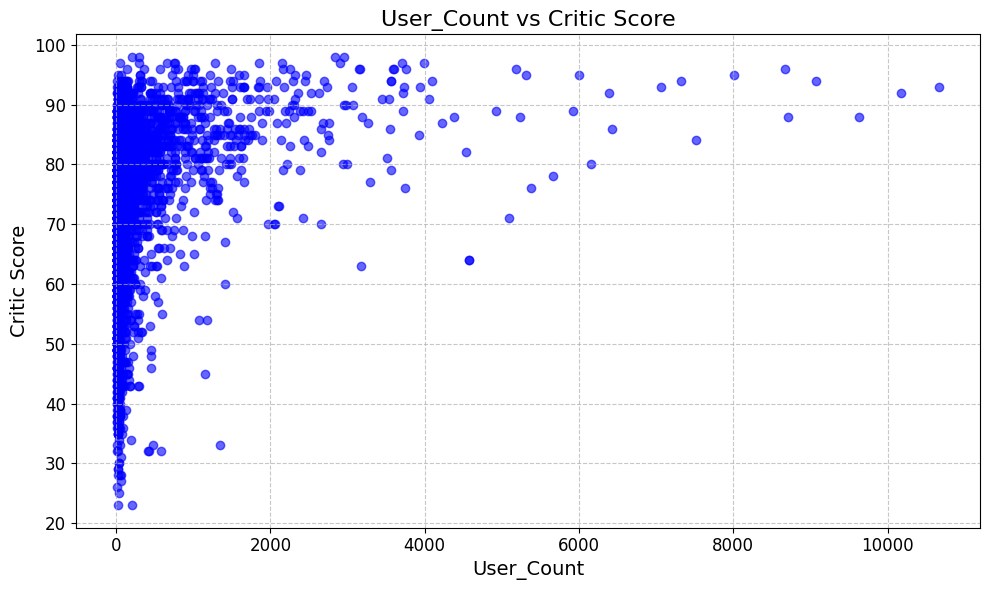

In [295]:
# Compare each numerical column to Global_Sales using scatter plots platform vs critic score [col should be going through platforms]
for col in numerical_columns:
    plt.figure(figsize=(10, 6))
    plt.scatter(df[col], df["Critic_Score"], alpha=0.6, color="blue")
    plt.title(f"{col} vs Critic Score", fontsize=16)
    plt.xlabel(col, fontsize=14)
    plt.ylabel("Critic Score", fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(axis="both", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()